In [1]:
import pandas as pd
from keras_preprocessing import image as im
import os
import numpy as np
import pickle


In [2]:
import tensorflow as tf

In [3]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    return df

In [4]:
annotations = load_data("../../../../images/", '../../../../emo-at-cap.csv')

# Cropping faces

In [9]:
!pip install tqdm

  Using cached tqdm-4.61.2-py2.py3-none-any.whl (76 kB)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [5]:
from skimage import transform
import datetime
import numpy as np
import cv2
from PIL import Image
import math
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
def get_outputs_names(net):
    layers_names = net.getLayerNames()
    return [layers_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

def post_process(frame, outs, conf_threshold, nms_threshold):
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]
    confidences = []
    boxes = []
    last_box=[]
    center = []
    class_ids = []
    result = []
    if True:

        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > conf_threshold:
                    center_x = int(detection[0] * frame_width)
                    center_y = int(detection[1] * frame_height)
                    width = int(detection[2] * frame_width)
                    height = int(detection[3] * frame_height)
                    left = int(center_x - width / 2)
                    top = int(center_y - height / 2)
                    confidences.append(float(confidence))
                    boxes.append([left, top, width, height])
                    center.append([center_x, center_y])
                    class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold,
                               nms_threshold)
    for i in indices:
            i = i[0]
            box = boxes[i]
            left = box[0]
            top = box[1]
            width = box[2]
            height = box[3]

            center_x = center[i][0]
            center_y = center[i][1]

            result.append(box)
    return result


In [ ]:
CONF_THRESHOLD = 0.95
NMS_THRESHOLD = 0.95
IMG_WIDTH = 416
IMG_HEIGHT = 416
model_cfg = 'yolov3-face.cfg'
model_weights = 'yolov3-wider_16000.weights'

In [8]:
net = cv2.dnn.readNetFromDarknet(model_cfg, model_weights)

net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [59]:
faces = []
for path in tqdm(annotations['image_name'].values):
    frame = cv2.imread(path)    
    blob = cv2.dnn.blobFromImage(frame, 1 / 255, (IMG_WIDTH, IMG_HEIGHT),
                                [0, 0, 0], 1, crop=False)
    net.setInput(blob)


    outs = net.forward(get_outputs_names(net))

    tmp_faces = post_process(frame, outs, CONF_THRESHOLD, NMS_THRESHOLD
                                       )
        
    faces.append(tmp_faces)

100%|██████████| 3840/3840 [48:38<00:00,  1.32it/s] 


In [60]:
len([i for i in faces if not i])

164

In [ ]:
with open('crop_regions.pl', 'wb') as f:
    pickle.dump(faces,f)

In [7]:
face_regions = pickle.load(open('crop_regions.pl', 'rb'))

In [8]:
def crop_faces(image, faces):
    if not faces:
        return []
    crop_faces = [(faces[i][0], faces[i][1], faces[i][2] + faces[i][0], faces[i][3] + faces[i][1]) for i in
                  range(len(faces))]
    cropped = []
    for i in range(len(crop_faces)):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cropped.append(np.array(Image.fromarray(np.asarray(image)).crop(crop_faces[i]).convert('RGB')))
    return cropped

In [9]:
images = []
for path in tqdm(annotations['image_name'].values):
        images.append(cv2.imread(path))  


100%|██████████| 3840/3840 [00:05<00:00, 690.15it/s]


In [10]:
cropped_faces = []
for image, face_region in tqdm(zip(images[:len(face_regions)],face_regions)):
    cropped_faces.append(crop_faces(image, face_region))

3840it [00:04, 829.64it/s] 


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

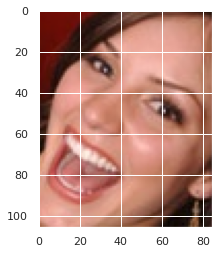

In [12]:
plt.imshow(cropped_faces[12][6])

# Making features of emotions

In [68]:
img_height, img_width = 197, 197

In [18]:
def resize(images, img_height, img_width):
    if isinstance(images,list):
        if not images:
            return []
    new_images = []
    for face in images:
        new_images.append(np.array(Image.fromarray(face).resize((img_height, img_width), Image.ANTIALIAS)))
    return new_images

In [86]:
emotions_cropped_faces = []
for i in tqdm(cropped_faces):
    emotions_cropped_faces.append(resize(i, img_height, img_width))

100%|██████████| 3840/3840 [00:19<00:00, 192.50it/s]


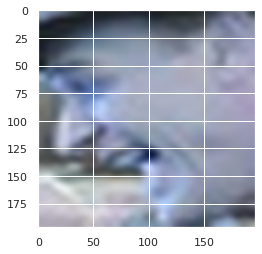

In [106]:
plt.imshow(emotions_cropped_faces[14][3])

In [89]:
emotion_model = tf.keras.models.load_model('ResNet-50.h5')

In [98]:
emotions = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

In [107]:
emotions[np.argmax(emotion_model.predict(np.expand_dims(emotions_cropped_faces[14][3]/255,axis=0)))]

'Happy'

In [14]:
emotion_features = []
for faces in tqdm(emotions_cropped_faces):
    if isinstance(faces, list) and not faces:
            emotion_features.append(np.array([1/len(emotions) for i in range(len(emotions))]))
    else:
        probs = emotion_model.predict(np.array(faces)).sum(axis=0)
        probs = probs/probs.sum()
        emotion_features.append(probs)
    

NameError: name 'emotions_cropped_faces' is not defined

In [116]:
with open('emotion_features.pl', 'wb') as f:
    pickle.dump(emotion_features, f)

# Gender features

In [20]:
!pip install tensorflow-gpu==2.3.0

     |████████████████████████████████| 320.4 MB 26 kB/s s eta 0:00:01
     |████████████████████████████████| 6.0 MB 58.8 MB/s eta 0:00:01
     |████████████████████████████████| 26.1 MB 54.0 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.1 MB/s  eta 0:00:01
     |████████████████████████████████| 459 kB 58.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 56.0 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 59.4 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
      Successfully uninstalled tensorflow-estimator-2.1.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.3
    Uninstalling scipy-1.5.3:
      Successfully uninstalled

In [13]:
age_gender_model = tf.keras.models.load_model('EfficientNetB3_224_weights.11-3.44.hdf5')

In [16]:
age_gender_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [16]:
img_height, img_width = 224, 224

In [19]:
gender_cropped_faces = []
for i in tqdm(cropped_faces):
    gender_cropped_faces.append(resize(i, img_height, img_width))

100%|██████████| 3840/3840 [00:24<00:00, 159.32it/s]


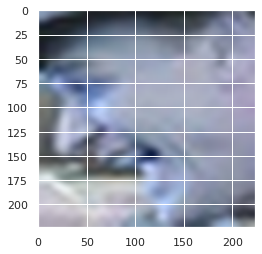

In [20]:
plt.imshow(gender_cropped_faces[14][3])

In [21]:
age_gender_model.predict(np.expand_dims(gender_cropped_faces[14][3],axis=0))[0]

array([[0.5791926 , 0.42080745]], dtype=float32)

In [30]:
gender_features = []
for faces in tqdm(gender_cropped_faces):
    if isinstance(faces, list) and not faces:
            gender_features.append(np.array([0.5 for i in range(5)]))
    else:
        probs = age_gender_model.predict(np.array(faces))[0]
        man_probs = probs[:,0]
        woman_probs = probs[:,1]
        tmp = 0
        for c, i in enumerate(woman_probs):
            if c==0:
                tmp=i
                continue
            tmp = tmp*i
        prob_at_least_one_man = 1-tmp
        tmp = 0
        for c, i in enumerate(man_probs):
            if c==0:
                tmp=i
                continue
            tmp = tmp*i
        prob_at_least_one_woman = 1-tmp
        prob_at_least_one_woman_and_man = prob_at_least_one_man*prob_at_least_one_woman
        average_probs = probs.mean(axis=0)
        gender_features.append([prob_at_least_one_woman, prob_at_least_one_man,prob_at_least_one_woman_and_man, *average_probs])
    

100%|██████████| 3840/3840 [05:16<00:00, 12.12it/s]


In [35]:
gender_features = [i[:5] for i in gender_features]

In [36]:
with open('gender_features', 'wb') as f:
    pickle.dump(gender_features, f)